In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
from datetime import date, timedelta
import re
from statistics import mean
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Data

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [8]:
#Бинарные признаки для NaN

df['Number of Reviews NAN'] = df['Number of Reviews'].isna()
df['Number of Reviews NAN'] = df['Number of Reviews NAN'].apply(lambda x: 1 if False else 0)
df['Number of Reviews not NAN'] = df['Number of Reviews NAN'].apply(lambda x: 0 if x == 1 else 1)

df['Cuisine Style NAN'] = df['Cuisine Style'].isna()
df['Cuisine Style NAN'] = df['Cuisine Style NAN'].apply(lambda x: 1 if False else 0)
df['Cuisine Style not NAN'] = df['Cuisine Style NAN'].apply(lambda x: 0 if x == 1 else 1)

df['Price Range NAN'] = df['Price Range'].isna()
df['Price Range NAN'] = df['Price Range NAN'].apply(lambda x: 1 if False else 0)
df['Price Range not NAN'] = df['Price Range NAN'].apply(lambda x: 0 if x == 1 else 1)

# show time begins

In [9]:
#Справочник о городах
city_info = {
    'Munich':
    {
        'capital': 0,
        'population': 1456000,
        'numberofrestaraunts': 3018,
        'country': 'Germany'
    },
    'Oporto':
    {
        'capital': 0,
        'population': 214000,
        'numberofrestaraunts': 1902,
        'country': 'Portugal'
    },
    'Milan':
    {
        'capital': 0,
        'population': 1352000,
        'numberofrestaraunts': 7000,
        'country': 'Italy'
    },
    'Barcelona':
    {
        'capital': 0,
        'population': 5515000,
        'numberofrestaraunts': 9309,
        'country': 'Spain'
    },
    'Zurich':
    {
        'capital': 0,
        'population': 402000,
        'numberofrestaraunts': 1792,
        'country': 'Switzerland'
    },
    'Lyon':
    {
        'capital': 0,
        'population': 513000,
        'numberofrestaraunts': 2701,
        'country': 'France'
    },
    'Hamburg':
    {
        'capital': 0,
        'population': 1822000,
        'numberofrestaraunts': 3138,
        'country': 'Germany'
    },
    'Geneva':
    {
        'capital': 0,
        'population': 495000,
        'numberofrestaraunts': 1665,
        'country': 'Switzerland'
    },
    'Krakow':
    {
        'capital': 0,
        'population': 769000,
        'numberofrestaraunts': 1621,
        'country': 'Poland'
    },
    'Paris':
    {
        'capital': 1,
        'population': 2148000,
        'numberofrestaraunts': 16684,
        'country': 'France'
    },
    'Stockholm':
    {
        'capital': 1,
        'population': 974000,
        'numberofrestaraunts': 2882,
        'country': 'Sweden'
    },
    'London':
    {
        'capital': 1,
        'population': 8899000,
        'numberofrestaraunts': 19374,
        'country': 'England'
    },
    'Berlin':
    {
        'capital': 1,
        'population': 3748000,
        'numberofrestaraunts': 6962,
        'country': 'Germany'
    },
    'Bratislava':
    {
        'capital': 1,
        'population': 424000,
        'numberofrestaraunts': 1201,
        'country': 'Slovakia'
    },
    'Vienna':
    {
        'capital': 1,
        'population': 1889000,
        'numberofrestaraunts': 3951,
        'country': 'Austria'
    },
    'Rome':
    {
        'capital': 1,
        'population': 2873000,
        'numberofrestaraunts': 10558,
        'country': 'Italy'
    },
    'Madrid':
    {
        'capital': 1,
        'population': 6549000,
        'numberofrestaraunts': 10891,
        'country': 'Spain'
    },
    'Dublin':
    {
        'capital': 1,
        'population': 1361000,
        'numberofrestaraunts': 2298,
        'country': 'Ireland'
    },
    'Brussels':
    {
        'capital': 1,
        'population': 1831000,
        'numberofrestaraunts': 3525,
        'country': 'Belgium'
    },
    'Warsaw':
    {
        'capital': 1,
        'population': 1708000,
        'numberofrestaraunts': 3040,
        'country': 'Poland'
    },
    'Budapest':
    {
        'capital': 1,
        'population': 1750000,
        'numberofrestaraunts': 2917,
        'country': 'Hungary'
    },
    'Copenhagen':
    {
        'capital': 1,
        'population': 602000,
        'numberofrestaraunts': 2329,
        'country': 'Denmark'
    },
    'Amsterdam':
    {
        'capital': 1,
        'population': 821000,
        'numberofrestaraunts': 3847,
        'country': 'The Netherlands'
    },
    'Lisbon':
    {
        'capital': 1,
        'population': 504000,
        'numberofrestaraunts': 4682,
        'country': 'Portugal',
    },
    'Prague':
    {
        'capital': 1,
        'population': 1319000,
        'numberofrestaraunts': 5213,
        'country': 'The Czech Republic'
    },
    'Oslo':
    {
        'capital': 1,
        'population': 673000,
        'numberofrestaraunts': 1303,
        'country': 'Norway'
    },
    'Helsinki':
    {
        'capital': 1,
        'population': 631000,
        'numberofrestaraunts': 1478,
        'country': 'Finland'
    },
    'Edinburgh':
    {
        'capital': 1,
        'population': 488000,
        'numberofrestaraunts': 1852,
        'country': 'Scotland'
    },
    'Ljubljana':
    {
        'capital': 1,
        'population': 284000,
        'numberofrestaraunts': 583,
        'country': 'Slovenia'
    },
    'Athens':
    {
        'capital': 1,
        'population': 664000,
        'numberofrestaraunts': 2441,
        'country': 'Greece'
    },
    'Luxembourg':
    {
        'capital': 1,
        'population': 115000,
        'numberofrestaraunts': 716,
        'country': 'Luxembourg'
    }
}

### Признак 1: столица/не столица

In [10]:
df['Capital'] = df['City'].apply(lambda x: city_info[x]['capital'])
df['Not_capital'] = df['Capital'].apply(lambda x: 1 if x == 0 else 0)

### Признак 2: название страны

In [11]:
df['Country_name'] = df['City'].apply(lambda x: city_info[x]['country'])

### Признак 2.1: население города

In [12]:
df['Population'] = df['City'].apply(lambda x: city_info[x]['population'])

### Признак 2.2: количество ресторанов

In [13]:
df['num_restaurants'] = df['City'].apply(lambda x: city_info[x]['numberofrestaraunts'])

### Признак 3: индекс отношения количества ресторанов на душу населения

In [14]:
df['restaraunts_per_people'] = df['City'].apply(lambda x: (city_info[x]['numberofrestaraunts'] / city_info[x]['population']))

### Признак 3.1: индекс отношения населения на количество ресторанов

In [15]:
df['people_per_restaraunts'] = df['City'].apply(lambda x: (city_info[x]['population'] / city_info[x]['numberofrestaraunts']))

### Признак 3.2: относительный рейтинг по городу

In [16]:
df['ranking_per_city'] = df['Ranking'] / df['num_restaurants']

### Признак 4: презентабельный вид для ранга цен

In [17]:
price_dict = {'$': 10, '$$ - $$$': 100, '$$$$': 1000}
df['Price'] = df['Price Range'].map(price_dict)
#Пропуски заполняем медианным значением
df['Price'] = df['Price'].fillna(df['Price'].median())

### Признак 5: индекс отношения количества кухонь в ресторане к среднему количеству кухонь в ресторане

In [18]:
#Считаем, сколько кухонь в общем представлено в непустых значениях
cuisine = df['Cuisine Style'].dropna()
all_cuisines = []
list_cuisines = set()
cuisine = cuisine.str[1:-1].str.split(', ')
for i in cuisine:
    for a in i:
        all_cuisines.append(a)
        list_cuisines.add(a)
#Предполагаем, что в пропущенных значений есть хотя бы одна кухня
#Cчитаем среднее кол-во кухонь в ресторане
sum_na = df['Cuisine Style'].isna().sum()
avg_cuisines = (len(all_cuisines) + sum_na) / df.shape[0]

#Добавление признака
numtoavg_cuis = []
for i in df['Cuisine Style']:
    if type(i) == float:
        #В пропущенных значениях, есть хотя бы один ресторан, делим 1 на среднее
        numtoavg_cuis.append(1 / avg_cuisines)
    if type(i) == str:
        row = i[1:-1].split(', ')
        numtoavg_cuis.append(len(row) / avg_cuisines)
df['num to average cuisines'] = pd.Series(numtoavg_cuis)    

### Признак 6: индекс относительной популярности кухонь

In [19]:
#Узнаем относительную(?) популярность каждой кухни
cuisine_popularity = dict(pd.Series(all_cuisines).value_counts(normalize=True))

#Создаю столбец, в котором вместо названий кухонь ресторана будет указана индекс популярности кухонь.
#Если в ресторане не одна кухня - нахожу max значение.
#Пропуски заполняю нулями.
index_popular_cuisines = []
for i in df['Cuisine Style']:
    if type(i) == float:
        index_popular_cuisines.append(0)
    if type(i) == str:
        row = i[1:-1].split(', ')
        index_popular_cuisines.append(row)
df['index_popular_cuisines'] = pd.Series(index_popular_cuisines)
df['index_popular_cuisines'] = df['index_popular_cuisines'].apply(lambda x: max([cuisine_popularity[each] for each in x]) if x != 0 else x)

### Признак 7: наличие уникальной кухни в ресторане

In [20]:
# Количество представлений кухонь в ресторанах
total_top = pd.Series(all_cuisines).value_counts()
total_top[total_top == 1]
#По-дурацки создадим признак наличия уникальной кухни
unique_cuisines = []
for i in df['Cuisine Style']:
    if type(i) == float:
        unique_cuisines.append(0)
    else:
        if 'Xinjiang' in i or 'Salvadoran' in i or 'Latvian' in i or 'Yunnan' in i or 'Burmese' in i:
            unique_cuisines.append(1)
        else:
            unique_cuisines.append(0)
df['unique_cuisines'] = pd.Series(unique_cuisines)
df['not_unique_cuisines'] = df['unique_cuisines'].apply(lambda x: 0 if x == 1 else 1)

### Признак 8: количество дней с момента последнего отзыва

In [21]:
#Сначала заменим NaN на локальное обозначение пропущенных значений - [[], []]
df['Reviews'] = df['Reviews'].apply(lambda x: str([[], []]) if type(x) == float else x) 
df['Reviews'] = df['Reviews'].apply(lambda x: str(x) if type(x) == list else x)
res = []
for i in df['Reviews']:
    res.append(re.findall(r'(\d\d/\d\d/\d\d\d\d)', i))
reviews = pd.DataFrame(res)
reviews[0] = pd.to_datetime(reviews[0])
reviews[1] = pd.to_datetime(reviews[1])

today = pd.to_datetime(date.today().strftime('%Y-%m-%d'))

fromtoday = []
#В датасете запечетлены или 2 отзыва (причем нужно сравнить, какой более старый), или 1, или 0.
#Если надо, сравниваем и выбираем свежий отзыв.
for i in range(len(reviews)):
    if reviews.loc[i, 0] > reviews.loc[i, 1]:
        fromtoday.append(today - reviews.loc[i, 0])
    elif reviews.loc[i, 0] < reviews.loc[i, 1]:
        fromtoday.append(today - reviews.loc[i, 1])
    else:
        fromtoday.append(0)

#Пропущенные значения оставляем нулем, потому что (вроде как) на значение МАЕ сильно не повлияло
df['fromtoday'] = pd.Series(fromtoday)
df['fromtoday'] = df['fromtoday'].apply(lambda x: x.days if (type(x) != int) else 0)
#Хотя нет, попробуем средним
#fromtoday_mean = df[df['fromtoday'] != 0]['fromtoday'].mean()
#df['fromtoday'] = df['fromtoday'].apply(lambda x: fromtoday_mean if x == 0 else x)

### Признак 9: количество дней между двумя отзывами

In [22]:
df['delta_days'] = reviews[0] - reviews[1]
df['delta_days'] = df['delta_days'].apply(lambda x: x.days if type(x) != float else 0)
df['delta_days'] = df['delta_days'].fillna(0)

### Признак 10: сетевой ресторан или нет

In [23]:
df.columns
df.tail()
df['id'] = df['Restaurant_id'].apply(lambda x: int(x[3:]))
id_restaurants = pd.Series(df['id'].value_counts())
chain_restaurants = id_restaurants[id_restaurants > 1]
df['chain_restaurants'] = df['id'].apply(lambda x: 1 if x in chain_restaurants else 0)
df['not_chain_restaurants'] = df['chain_restaurants'].apply(lambda x: 1 if x == 0 else 0)

### Признак +: те самые фиктивные переменные

для стран и городов трансформация с помощью LabelEncoder() показала лучший МАЕ

In [24]:
df_cities = pd.get_dummies(df['City'], drop_first='True')
df_countries = pd.get_dummies(df['Country_name'], drop_first='True')
df_price = pd.get_dummies(df['Price'], drop_first='True')
df_price.columns = ['$$-$$$', '$$$$']

df['len_cuisine'] = df['Cuisine Style'].apply(lambda x: list(x[1:-1].split(', ')) if type(x) != float else 0)
df_cuisines = pd.DataFrame()

def find_item(cell):
    if cell == 0:
        return 0
    else:
        if item in cell:
            return 1
        return 0

for item in list_cuisines:
    df_cuisines[item] = df['len_cuisine'].apply(find_item)
df['len_cuisine'] = df['len_cuisine'].apply(lambda x: len(x) if x != 0 else 1) #у пропущенных все равно кухня есть

In [25]:
#cities_le = LabelEncoder()
#cities_le.fit(df['City'])
#df['City Code'] = cities_le.transform(df['City'])

#countries_le = LabelEncoder()
#cities_le.fit(df['Country_name'])
#df['Country Code'] = cities_le.transform(df['Country_name'])

#### Забытые NaN

In [26]:
#заполняем пропуски нулями
df['Number of Reviews'] = df['Number of Reviews'].fillna(0)

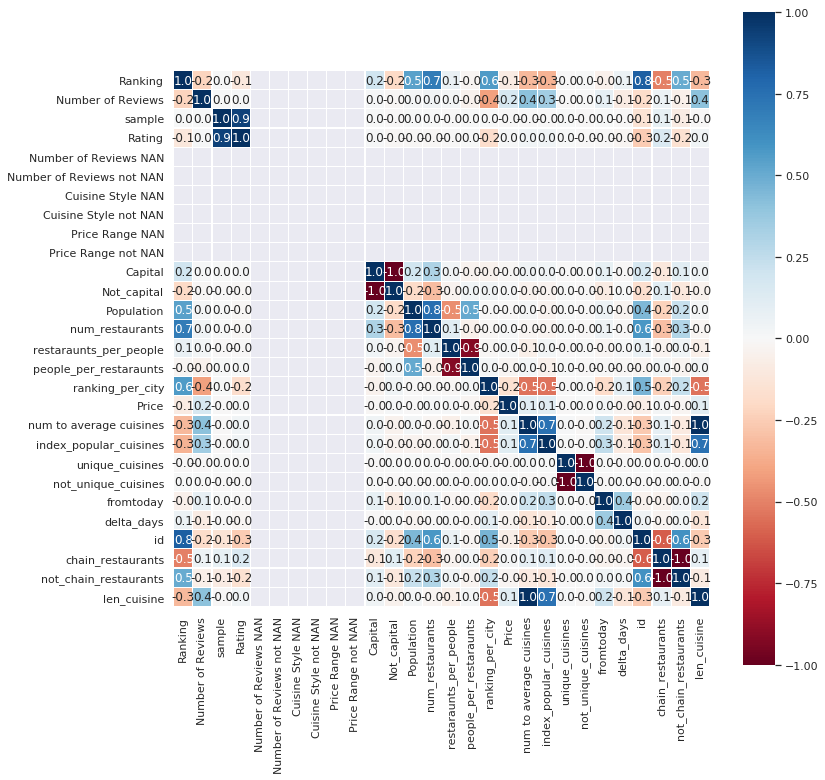

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(df.corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

In [30]:
df = df.drop(['Not_capital', 'num_restaurants', 'people_per_restaraunts', 'index_popular_cuisines', 'not_unique_cuisines', 'not_chain_restaurants'], axis=1)

In [31]:
df_output = df.drop(['Restaurant_id', 'City', 'Cuisine Style', 'Reviews', 'Price Range', 'URL_TA', 'ID_TA', 'Country_name', 'id'], axis=1)
df_output = pd.concat([df_output, df_price, df_cities, df_countries, df_cuisines], axis = 1)
df_output.head()

,Ranking,Number of Reviews,sample,Rating,Number of Reviews NAN,Number of Reviews not NAN,Cuisine Style NAN,Cuisine Style not NAN,Price Range NAN,Price Range not NAN,...,'Uzbek','Brazilian','Southwestern','Chilean','Salvadoran','Xinjiang','Latvian','Slovenian','Japanese','Latin'
0,12963.0,4.0,0,0.0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,106.0,97.0,0,0.0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,810.0,28.0,0,0.0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1669.0,202.0,0,0.0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,37.0,162.0,0,0.0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Теперь выделим тестовую часть
train_data = df_output.query('sample == 1').drop(['sample'], axis=1)
test_data = df_output.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [33]:
# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [34]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 199), (40000, 199), (40000, 198), (32000, 198), (8000, 198))

## Model

In [35]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [36]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [37]:
def round_output(result):
    if result <= 0.25:
        return 0
    elif 0.25 < result <= 0.75:
        return 0.5
    elif 0.75 < result <= 1.25:
        return 1
    elif 1.25 < result <= 1.75:
        return 1.5
    elif 1.75 < result <= 2.25:
        return 2
    elif 2.25 < result <= 2.75:
        return 2.5
    elif 2.75 < result <= 3.25:
        return 3
    elif 3.25 < result <= 3.75:
        return 3.5
    elif 3.75 < result <= 4.25:
        return 4
    elif 4.25 < result <= 4.75:
        return 4.5
    else:
        return 5
    
for i in range(y_pred.size):
    y_pred[i] = round_output(y_pred[i])

In [38]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1714375


### Submission

In [39]:
test_data = test_data.drop(['Rating'], axis=1)
predict_submission = model.predict(test_data)
predict_submission
sample_submission['Rating'] = predict_submission
sample_submission['Rating'] = sample_submission['Rating'].apply(round_output)
sample_submission.to_csv('submission_new_forked.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5
